<a href="https://colab.research.google.com/github/kaneelgit/ML-DL-Algorithms/blob/main/contrastive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center> **Contrastive Learning** </center></font>

Paper - https://arxiv.org/pdf/2002.05709.pdf

In [1]:
#import libraries
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [144]:
#hyperparameters
AUTO = tf.data.AUTOTUNE
batch_size = 32
epochs = 100
crop_to = 32
img_size = 32
random_seed = 26 
project_dim = 2048
latent_dim = 512
weight_decay = 0.0005

In [145]:
#get the cifar-10 dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(f'Total training images: {x_train.shape[0]} & Shape of training data: {x_train.shape}')
print(f'Total testing images: {x_test.shape[0]} & Shape of testing data: {x_test.shape}')

Total training images: 50000 & Shape of training data: (50000, 32, 32, 3)
Total testing images: 10000 & Shape of testing data: (10000, 32, 32, 3)


In [146]:
#defining a data augmentation pipeline
def flip_and_crop(img):
  """
  this function randomly randomly flip the images and crop them
  """

  #create random crops
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_crop(img, (crop_to, crop_to, 3))

  return img

def color_adjust(img, strength = [0.4, 0.4, 0.4, 0.1]):
  """
  this function randomly changes the brightness, contrast and saturation of the image
  """
  img = tf.image.random_brightness(img, max_delta = 0.8 * strength[0])
  img = tf.image.random_contrast(img, lower = 1 - 0.8 * strength[1], upper = 1 + 0.8 * strength[1])
  img = tf.image.random_saturation(img, lower = 1 - 0.8 * strength[2], upper = 1 + 0.8 * strength[2])
  img = tf.image.random_hue(img, max_delta = 0.2 * strength[3])
  img = tf.clip_by_value(img, 0, 255)

  return img

def color_drop(img):
  """
  drops the color to black and white
  """
  rand_prob = np.random.uniform(0, 1)
  color_or_not = np.random.choice([0, 1], p = [rand_prob, 1 - rand_prob])

  if color_or_not == 0:
    img = img
  else:
    img = tf.image.rgb_to_grayscale(img)
    img = tf.tile(img, [1, 1, 3])
  
  return img

def augment_image(img):
  """
  This function uses the above helper functions to augment images
  """
  img = flip_and_crop(img)
  img = color_adjust(img)
  img = color_drop(img)

  return img

In [147]:
#create tensorflow dataset objects

#create two datasets
train_ds_one = tf.data.Dataset.from_tensor_slices(X_train)
train_ds_one = (train_ds_one.shuffle(1024, seed = random_seed).map(augment_image, num_parallel_calls = AUTO).batch(batch_size).prefetch(AUTO))

train_ds_two = tf.data.Dataset.from_tensor_slices(X_train)
train_ds_two = (train_ds_two.shuffle(1024, seed = random_seed).map(augment_image, num_parallel_calls = AUTO).batch(batch_size).prefetch(AUTO))

train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

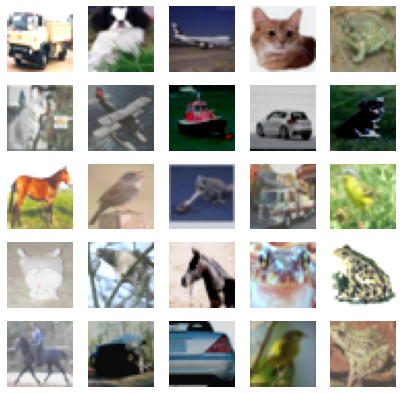

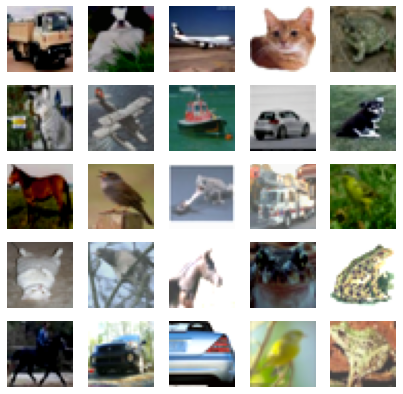

In [149]:
#plot some sample images from both datasets
sample_img_one = next(iter(train_ds_one))
plt.figure(figsize = (7, 7))

for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(sample_img_one[n].numpy().astype('int'))
  plt.axis('off')
plt.show()

#second dataset
sample_img_two = next(iter(train_ds_two))
plt.figure(figsize = (7, 7))

for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(sample_img_two[n].numpy().astype('int'))
  plt.axis('off')
plt.show()

In [150]:
!wget -q https://git.io/JYx2x -O resnet_cifar10_v2.py

In [152]:
import resnet_cifar10_v2 as resnet